# **Entrega 2: Nuevo Dataset y Entrenamiento de Modelos**



*   M. Valentina Castro
*   Santiago Cárdenas
*   David Molta




In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Modelos
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score
)

# Configuración de gráficas
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Cargar CSV
df_raw = pd.read_csv('motion_data_entrega2.csv')

print(f"Dataset cargado: {df_raw.shape}")
print(f"\nColumnas: {len(df_raw.columns)}")
df_raw.head()

Dataset cargado: (4399, 138)

Columnas: 138


,frame_number,clip_name,coord_x_0,coord_y_0,coord_z_0,confidence_0,coord_x_1,coord_y_1,coord_z_1,confidence_1,...,coord_z_31,confidence_31,coord_x_32,coord_y_32,coord_z_32,confidence_32,movement_type,speed,camera_angle,camera_distance
0,13,Adelante_Lento_Centro_Cerca.mp4,0.145786,0.831212,-0.192980,0.968410,0.154933,0.837625,-0.222373,0.960158,...,0.078209,0.223389,0.098430,0.702435,0.312505,0.090072,caminar_adelante,lento,Centro,Cerca
1,14,Adelante_Lento_Centro_Cerca.mp4,0.141190,0.830624,-0.105090,0.967180,0.154717,0.839243,-0.127801,0.959875,...,0.010112,0.224492,0.091148,0.703466,0.190982,0.091250,caminar_adelante,lento,Centro,Cerca
2,15,Adelante_Lento_Centro_Cerca.mp4,0.146676,0.834547,0.030616,0.967366,0.160302,0.840530,0.006753,0.960517,...,-0.045836,0.223276,0.086657,0.711314,0.134295,0.096114,caminar_adelante,lento,Centro,Cerca
3,16,Adelante_Lento_Centro_Cerca.mp4,0.135671,0.836773,0.001077,0.968096,0.157984,0.842521,-0.017611,0.961277,...,0.031465,0.210945,0.099532,0.805248,0.188335,0.094065,caminar_adelante,lento,Centro,Cerca
4,17,Adelante_Lento_Centro_Cerca.mp4,0.134275,0.837998,-0.036210,0.969694,0.146348,0.842373,-0.056253,0.963132,...,0.029076,0.214194,0.112159,0.777486,0.189646,0.105636,caminar_adelante,lento,Centro,Cerca


In [3]:
print("="*70)
print("VERIFICACIÓN DE DATOS")
print("="*70)

# Valores faltantes
missing = df_raw.isnull().sum().sum()
print(f"\nValores faltantes: {missing}")

# Distribución de clases
print("\n DISTRIBUCIÓN DE ACTIVIDADES:")
print(df_raw['movement_type'].value_counts())
print(f"\nTotal frames: {len(df_raw)}")

# Velocidades
print("\n VELOCIDADES:")
print(df_raw['speed'].value_counts())

# Clips
print(f"\n CLIPS ÚNICOS: {df_raw['clip_name'].nunique()}")

VERIFICACIÓN DE DATOS

Valores faltantes: 0

 DISTRIBUCIÓN DE ACTIVIDADES:
movement_type
girar               1467
sentarse             843
caminar_atras        775
levantarse           670
caminar_adelante     644
Name: count, dtype: int64

Total frames: 4399

 VELOCIDADES:
speed
lento     2584
rapido    1815
Name: count, dtype: int64

 CLIPS ÚNICOS: 60


####  **Renombrar Landmarks Críticos**

Vamos a renombrar los 11 landmarks más importantes para que sean fáciles de entender:
- 0: nariz
- 11, 12: hombros
- 23, 24: caderas
- 25, 26: rodillas
- 27, 28: tobillos

In [10]:
# Landmarks críticos
critical_landmarks = {
    0: 'nose',
    11: 'left_shoulder', 12: 'right_shoulder',
    15: 'left_wrist', 16: 'right_wrist',
    23: 'left_hip', 24: 'right_hip',
    25: 'left_knee', 26: 'right_knee',
    27: 'left_ankle', 28: 'right_ankle'
}

df = df_raw.copy()

# Renombrar
rename_map = {}
for idx, name in critical_landmarks.items():
    rename_map[f'coord_x_{idx}'] = f'{name}_x'
    rename_map[f'coord_y_{idx}'] = f'{name}_y'
    rename_map[f'coord_z_{idx}'] = f'{name}_z'
    rename_map[f'confidence_{idx}'] = f'{name}_confidence'

df = df.rename(columns=rename_map)

print(f"\nEjemplo de nuevas columnas:")
print([col for col in df.columns if 'hip' in col][:8])



Ejemplo de nuevas columnas:
['left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_confidence', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_confidence']


#### **Normalización en Y**

Normalizamos las coordenadas Y para que la posición vertical sea relativa (no importa si la persona está más cerca o lejos de la cámara).

In [11]:
# Normalizar Y por clip
for clip in df['clip_name'].unique():
    mask = df['clip_name'] == clip
    y_cols = [col for col in df.columns if '_y' in col and 'coord_y' in col]

    for col in y_cols:
        y_values = df.loc[mask, col]
        y_range = y_values.max() - y_values.min()
        if y_range > 0:
            df.loc[mask, col] = (y_values - y_values.min()) / y_range


#### **Feature Engineering: Rasgos Dinámicos**

Ahora agregamos información de **movimiento**:
- Velocidad en X e Y (qué tan rápido se mueve cada landmark)
- Magnitud de velocidad (velocidad total combinando X e Y)
- Aceleración (cambio en la velocidad)

 Información clave porque las actividades se diferencian por cómo se mueven, no solo por la posición.

In [12]:
def add_dynamic_features(df, landmarks_dict):
    # Agrega velocidades y aceleraciones
    df = df.sort_values(['clip_name', 'frame_number']).reset_index(drop=True)

    for name in landmarks_dict.values():
        # Velocidad en X e Y
        df[f'{name}_velocity_x'] = df.groupby('clip_name')[f'{name}_x'].diff()
        df[f'{name}_velocity_y'] = df.groupby('clip_name')[f'{name}_y'].diff()

        # Magnitud de velocidad
        df[f'{name}_velocity_magnitude'] = np.sqrt(
            df[f'{name}_velocity_x']**2 + df[f'{name}_velocity_y']**2
        )

        # Aceleración (cambio en velocidad)
        df[f'{name}_acceleration'] = df.groupby('clip_name')[f'{name}_velocity_magnitude'].diff()

    # Llenar valores NaN con 0 (primer frame de cada clip)
    df = df.fillna(0)
    return df

df = add_dynamic_features(df, critical_landmarks)

print(f"Dimensiones actuales: {df.shape}")
print(f"\nEjemplo de nuevas columnas:")
print([col for col in df.columns if 'velocity' in col][:5])

Dimensiones actuales: (4399, 182)

Ejemplo de nuevas columnas:
['nose_velocity_x', 'nose_velocity_y', 'nose_velocity_magnitude', 'left_shoulder_velocity_x', 'left_shoulder_velocity_y']


---
#### **2. Feature Engineering: 3 Vistas**

Creamos 3 conjuntos diferentes de features para comparar cuál da mejor resultado:

- **Vista A (Todo el cuerpo):** Usa TODOS los 33 landmarks
- **Vista B (Core/Torso):** Solo caderas + tronco + hombros (parte superior)
- **Vista C (Miembros Inferiores):** Solo caderas + rodillas + tobillos (piernas)

Esto responde: ¿necesitamos todo el cuerpo o bastan las piernas?

In [13]:
def create_feature_views(df):
    """Crea 3 vistas de features."""
    base_cols = ['frame_number', 'clip_name', 'movement_type', 'speed']

    # VISTA A: Todo el cuerpo (todos los landmarks)
    all_cols = [col for col in df.columns
                if col not in base_cols and col not in ['camera_angle', 'camera_distance']]
    view_a = df[base_cols + all_cols].copy()

    # VISTA B: Core (caderas + tronco + hombros)
    core_landmarks = ['nose', 'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    core_cols = [col for col in df.columns
                 if any(lm in col for lm in core_landmarks)]
    view_b = df[base_cols + core_cols].copy()

    # VISTA C: Miembros inferiores (caderas + rodillas + tobillos)
    lower_landmarks = ['left_hip', 'right_hip', 'left_knee', 'right_knee',
                       'left_ankle', 'right_ankle']
    lower_cols = [col for col in df.columns
                  if any(lm in col for lm in lower_landmarks)]
    view_c = df[base_cols + lower_cols].copy()

    return view_a, view_b, view_c

view_a, view_b, view_c = create_feature_views(df)

print("Vistas creadas")
print(f"\nVista A (Todo el cuerpo): {view_a.shape}")
print(f"Vista B (Core/Torso): {view_b.shape}")
print(f"Vista C (Piernas): {view_c.shape}")

Vistas creadas

Vista A (Todo el cuerpo): (4399, 180)
Vista B (Core/Torso): (4399, 44)
Vista C (Piernas): (4399, 52)


In [14]:
# Ver cuántas columnas tiene cada vista
print("\n" + "="*70)
print("ANÁLISIS DE COLUMNAS POR VISTA")
print("="*70)

print(f"\n📊 Vista A (Todo el cuerpo):")
print(f"   Total columnas: {view_a.shape[1]}")
print(f"   Features (sin metadatos): {view_a.shape[1] - 4}")
feature_cols_a = [col for col in view_a.columns if col not in ['frame_number', 'clip_name', 'movement_type', 'speed']]
print(f"   Ejemplos: {feature_cols_a[:5]}")

print(f"\n📊 Vista B (Core):")
print(f"   Total columnas: {view_b.shape[1]}")
print(f"   Features (sin metadatos): {view_b.shape[1] - 4}")
feature_cols_b = [col for col in view_b.columns if col not in ['frame_number', 'clip_name', 'movement_type', 'speed']]
print(f"   Landmarks usados: nose, left/right_shoulder, left/right_hip")
print(f"   Ejemplos: {feature_cols_b[:5]}")

print(f"\n📊 Vista C (Miembros Inferiores):")
print(f"   Total columnas: {view_c.shape[1]}")
print(f"   Features (sin metadatos): {view_c.shape[1] - 4}")
feature_cols_c = [col for col in view_c.columns if col not in ['frame_number', 'clip_name', 'movement_type', 'speed']]
print(f"   Landmarks usados: left/right_hip, left/right_knee, left/right_ankle")
print(f"   Ejemplos: {feature_cols_c[:5]}")

print("\n Diferencia:")
print(f"   Vista A tiene {len(feature_cols_a) - len(feature_cols_c)} features más que Vista C")
print(f"   Vista A tiene {len(feature_cols_a) - len(feature_cols_b)} features más que Vista B")


ANÁLISIS DE COLUMNAS POR VISTA

📊 Vista A (Todo el cuerpo):
   Total columnas: 180
   Features (sin metadatos): 176
   Ejemplos: ['nose_x', 'nose_y', 'nose_z', 'nose_confidence', 'coord_x_1']

📊 Vista B (Core):
   Total columnas: 44
   Features (sin metadatos): 40
   Landmarks usados: nose, left/right_shoulder, left/right_hip
   Ejemplos: ['nose_x', 'nose_y', 'nose_z', 'nose_confidence', 'left_shoulder_x']

📊 Vista C (Miembros Inferiores):
   Total columnas: 52
   Features (sin metadatos): 48
   Landmarks usados: left/right_hip, left/right_knee, left/right_ankle
   Ejemplos: ['left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_confidence', 'right_hip_x']

 Diferencia:
   Vista A tiene 128 features más que Vista C
   Vista A tiene 136 features más que Vista B


##### **Preparación para Modelado**

1. Separar features (X) y target (y)
2. Split train/val/test **estratificado por CLIP** (importante para evitar data leakage)
3. Normalizar features (StandardScaler)

In [15]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(view_df, test_size=0.2, val_size=0.125, random_state=42):
    # Prepara datos con split estratificado por clip.

    # Separar X (features) e y (target)
    X = view_df.drop(['movement_type', 'clip_name', 'frame_number', 'speed'], axis=1)
    y = view_df['movement_type']
    clips = view_df['clip_name']
    speed = view_df['speed']

    # Convertir etiquetas a números (para XGBoost)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split por CLIPS (no por frames individuales)
    unique_clips = clips.unique()
    clip_labels = view_df.groupby('clip_name')['movement_type'].first()

    # Train+Val vs Test
    clips_train_val, clips_test = train_test_split(
        unique_clips, test_size=test_size, random_state=random_state,
        stratify=clip_labels
    )

    # Train vs Val
    clip_labels_train_val = clip_labels[clips_train_val]
    clips_train, clips_val = train_test_split(
        clips_train_val, test_size=val_size, random_state=random_state,
        stratify=clip_labels_train_val
    )

    # Crear máscaras para seleccionar frames
    train_mask = clips.isin(clips_train)
    val_mask = clips.isin(clips_val)
    test_mask = clips.isin(clips_test)

    # Aplicar máscaras
    X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
    y_train, y_val, y_test = y_encoded[train_mask], y_encoded[val_mask], y_encoded[test_mask]
    speed_train, speed_val, speed_test = speed[train_mask], speed[val_mask], speed[test_mask]

    # Escalar features (media=0, std=1)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    print(f"Train: {X_train.shape[0]} frames, {len(clips_train)} clips")
    print(f"Val:   {X_val.shape[0]} frames, {len(clips_val)} clips")
    print(f"Test:  {X_test.shape[0]} frames, {len(clips_test)} clips")

    return {
        'X_train': X_train_scaled, 'X_val': X_val_scaled, 'X_test': X_test_scaled,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'speed_train': speed_train, 'speed_val': speed_val, 'speed_test': speed_test,
        'scaler': scaler, 'label_encoder': label_encoder,
        'feature_names': X.columns.tolist()
    }

In [16]:
print("\n" + "="*70)
print("PREPARANDO VISTA A: Todo el cuerpo")
print("="*70)
data_a = prepare_data(view_a)

print("\n" + "="*70)
print("PREPARANDO VISTA B: Core")
print("="*70)
data_b = prepare_data(view_b)

print("\n" + "="*70)
print("PREPARANDO VISTA C: Miembros Inferiores")
print("="*70)
data_c = prepare_data(view_c)

print("\n Todas las vistas preparadas para entrenamiento")


PREPARANDO VISTA A: Todo el cuerpo
Train: 3176 frames, 42 clips
Val:   489 frames, 6 clips
Test:  734 frames, 12 clips

PREPARANDO VISTA B: Core
Train: 3176 frames, 42 clips
Val:   489 frames, 6 clips
Test:  734 frames, 12 clips

PREPARANDO VISTA C: Miembros Inferiores
Train: 3176 frames, 42 clips
Val:   489 frames, 6 clips
Test:  734 frames, 12 clips

 Todas las vistas preparadas para entrenamiento


In [17]:
# Modelos base
models = {
    'SVM': SVC(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
}

# Grids de hiperparámetros
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.001, 0.01],
        'kernel': ['rbf']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    }
}

print(" Modelos y grids configurados")
print(f"\nSVM: {len(param_grids['SVM']['C']) * len(param_grids['SVM']['gamma'])} combinaciones")
print(f"RandomForest: {2 * 3 * 2} combinaciones")
print(f"XGBoost: {2 * 3 * 2} combinaciones")

 Modelos y grids configurados

SVM: 9 combinaciones
RandomForest: 12 combinaciones
XGBoost: 12 combinaciones


#### **3. Entrenamiento**

In [18]:
def train_model(model_name, model, param_grid, data, cv=3):
    # Entrena un modelo con Grid Search y evalúa en val/test.
    print(f"\n{'='*60}")
    print(f"Entrenando {model_name}...")
    print(f"{'='*60}")

    # Grid Search con validación cruzada
    grid = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(data['X_train'], data['y_train'])

    print(f"\n Mejores parámetros: {grid.best_params_}")
    print(f" F1-macro (CV en train): {grid.best_score_:.4f}")

    # Mejor modelo
    best_model = grid.best_estimator_

    # Predicciones en val y test
    y_val_pred = best_model.predict(data['X_val'])
    y_test_pred = best_model.predict(data['X_test'])

    # Métricas
    val_f1 = f1_score(data['y_val'], y_val_pred, average='macro')
    test_f1 = f1_score(data['y_test'], y_test_pred, average='macro')
    test_acc = accuracy_score(data['y_test'], y_test_pred)

    print(f"\nValidación F1:  {val_f1:.4f}")
    print(f"Test F1:        {test_f1:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")

    return {
        'model': best_model,
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'val_f1': val_f1,
        'test_f1': test_f1,
        'test_acc': test_acc,
        'y_val_pred': y_val_pred,
        'y_test_pred': y_test_pred
    }

##### **3.1 Vista A**

In [19]:
import time

results_a = {}
start_time = time.time()

print("ENTRENANDO VISTA A: TODO EL CUERPO (176 features)")

for model_name in ['SVM', 'RandomForest', 'XGBoost']:
    results_a[model_name] = train_model(
        model_name,
        models[model_name],
        param_grids[model_name],
        data_a,
        cv=3
    )

elapsed = time.time() - start_time
print(f"\n⏱️  Tiempo Vista A: {elapsed/60:.1f} minutos")

ENTRENANDO VISTA A: TODO EL CUERPO (176 features)

Entrenando SVM...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

 Mejores parámetros: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
 F1-macro (CV en train): 0.8223

Validación F1:  0.8646
Test F1:        0.8306
Test Accuracy:  0.8460

Entrenando RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
 F1-macro (CV en train): 0.8413

Validación F1:  0.7154
Test F1:        0.8760
Test Accuracy:  0.8896

Entrenando XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
 F1-macro (CV en train): 0.8338

Validación F1:  0.7296
Test F1:        0.8328
Test Accuracy:  0.8529

⏱️  Tiempo Vista A: 7.7 minutos


#### **3.2 Vista B**

In [20]:
results_b = {}
start_time = time.time()
print("ENTRENANDO VISTA B: CORE (40 features)")
for model_name in ['SVM', 'RandomForest', 'XGBoost']:
    results_b[model_name] = train_model(
        model_name,
        models[model_name],
        param_grids[model_name],
        data_b,
        cv=3
    )

elapsed = time.time() - start_time
print(f"\n⏱️  Tiempo Vista B: {elapsed/60:.1f} minutos")

ENTRENANDO VISTA B: CORE (40 features)

Entrenando SVM...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

 Mejores parámetros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
 F1-macro (CV en train): 0.7966

Validación F1:  0.8555
Test F1:        0.8567
Test Accuracy:  0.8719

Entrenando RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
 F1-macro (CV en train): 0.8272

Validación F1:  0.7871
Test F1:        0.8816
Test Accuracy:  0.8937

Entrenando XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
 F1-macro (CV en train): 0.8123

Validación F1:  0.7310
Test F1:        0.8373
Test Accuracy:  0.8529

⏱️  Tiempo Vista B: 2.6 minutos


#### **3.3 Vista C**

In [23]:
results_c = {}
start_time = time.time()

print("ENTRENANDO VISTA C: PIERNAS (48 features)")

for model_name in ['SVM', 'RandomForest', 'XGBoost']:
    results_c[model_name] = train_model(
        model_name,
        models[model_name],
        param_grids[model_name],
        data_c,
        cv=3
    )

elapsed = time.time() - start_time
print(f"\n⏱️  Tiempo Vista C: {elapsed/60:.1f} minutos")

print("\n" + "="*70)

print("Se entrenaron 9 modelos (3 algoritmos × 3 vistas)")

ENTRENANDO VISTA C: PIERNAS (48 features)

Entrenando SVM...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

 Mejores parámetros: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
 F1-macro (CV en train): 0.7791

Validación F1:  0.8503
Test F1:        0.7615
Test Accuracy:  0.7875

Entrenando RandomForest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
 F1-macro (CV en train): 0.7792

Validación F1:  0.7302
Test F1:        0.8070
Test Accuracy:  0.8283

Entrenando XGBoost...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

 Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
 F1-macro (CV en train): 0.7752

Validación F1:  0.7210
Test F1:        0.6997
Test Accuracy:  0.7275

⏱️  Tiempo Vista C: 2.9 minutos

Se entrenaron 9 modelos (3 algoritmos × 3 vistas)


#### **4. Evaluación y Comparación de Resultados**

In [24]:
# Tabla comparativa
comparison_data = []

for view_name, results in [('Vista A (Todo)', results_a),
                            ('Vista B (Core)', results_b),
                            ('Vista C (Piernas)', results_c)]:
    for model_name, result in results.items():
        comparison_data.append({
            'Vista': view_name,
            'Modelo': model_name,
            'F1-macro (CV)': result['cv_f1'],
            'F1-macro (Val)': result['val_f1'],
            'F1-macro (Test)': result['test_f1'],
            'Accuracy (Test)': result['test_acc']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-macro (Test)', ascending=False)

print("\n" + "="*80)
print("COMPARACIÓN DE TODOS LOS MODELOS Y VISTAS")
print("="*80)
print(comparison_df.to_string(index=False))

# Identificar el mejor
best_row = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f" MEJOR MODELO: {best_row['Modelo']} con {best_row['Vista']}")
print(f"   F1-macro (Test): {best_row['F1-macro (Test)']:.4f}")
print(f"   Accuracy (Test): {best_row['Accuracy (Test)']:.4f}")
print(f"{'='*80}")


COMPARACIÓN DE TODOS LOS MODELOS Y VISTAS
            Vista       Modelo  F1-macro (CV)  F1-macro (Val)  F1-macro (Test)  Accuracy (Test)
   Vista B (Core) RandomForest       0.827191        0.787146         0.881605         0.893733
   Vista A (Todo) RandomForest       0.841271        0.715357         0.875966         0.889646
   Vista B (Core)          SVM       0.796642        0.855510         0.856744         0.871935
   Vista B (Core)      XGBoost       0.812322        0.730974         0.837254         0.852861
   Vista A (Todo)      XGBoost       0.833770        0.729615         0.832835         0.852861
   Vista A (Todo)          SVM       0.822301        0.864581         0.830618         0.846049
Vista C (Piernas) RandomForest       0.779152        0.730183         0.806987         0.828338
Vista C (Piernas)          SVM       0.779077        0.850346         0.761501         0.787466
Vista C (Piernas)      XGBoost       0.775175        0.721041         0.699722         0.7275

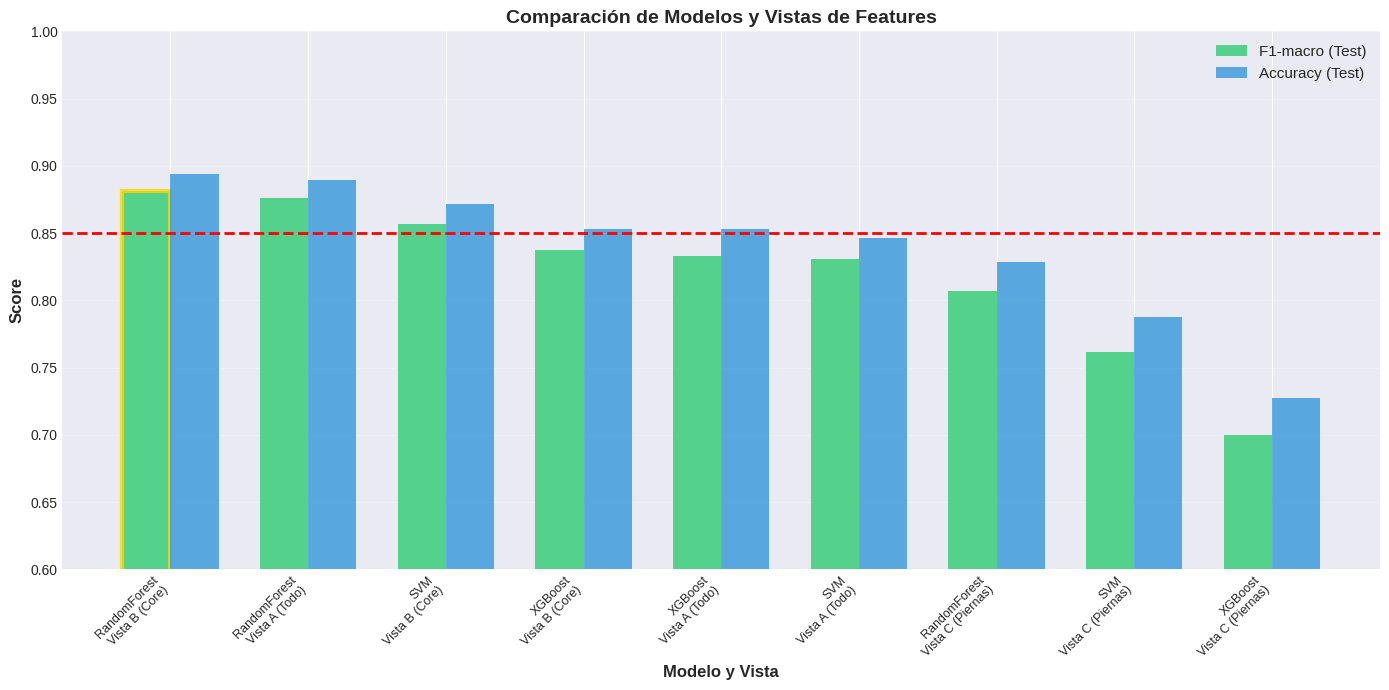

In [25]:
# Gráfica de barras comparativa
fig, ax = plt.subplots(figsize=(14, 7))

# Preparar datos para graficar
x = np.arange(len(comparison_df))
width = 0.35

# Barras
bars1 = ax.bar(x - width/2, comparison_df['F1-macro (Test)'], width,
               label='F1-macro (Test)', alpha=0.8, color='#2ecc71')
bars2 = ax.bar(x + width/2, comparison_df['Accuracy (Test)'], width,
               label='Accuracy (Test)', alpha=0.8, color='#3498db')

# Etiquetas y título
ax.set_xlabel('Modelo y Vista', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Modelos y Vistas de Features', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{row['Modelo']}\n{row['Vista']}"
                     for _, row in comparison_df.iterrows()],
                    rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.6, 1.0])

# Línea de objetivo F1=0.85
ax.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Objetivo (F1=0.85)')

# Destacar el mejor
best_idx = 0
ax.patches[best_idx].set_edgecolor('gold')
ax.patches[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

### **4.1 Análisis Detallado del Mejor Modelo**

Ahora analizamos a fondo el **Random Forest con Vista B (Core)**

In [26]:
# Identificar el mejor modelo
best_view = 'Vista B (Core)'
best_model_name = 'RandomForest'

# Obtener datos y resultados
best_result = results_b['RandomForest']
best_data = data_b
best_model = best_result['model']

print(f" Analizando: {best_model_name} con {best_view}")
print(f"  F1-macro (Test): {best_result['test_f1']:.4f}")
print(f"  Accuracy (Test): {best_result['test_acc']:.4f}")
print(f"  Mejores hiperparámetros: {best_result['best_params']}")

 Analizando: RandomForest con Vista B (Core)
  F1-macro (Test): 0.8816
  Accuracy (Test): 0.8937
  Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


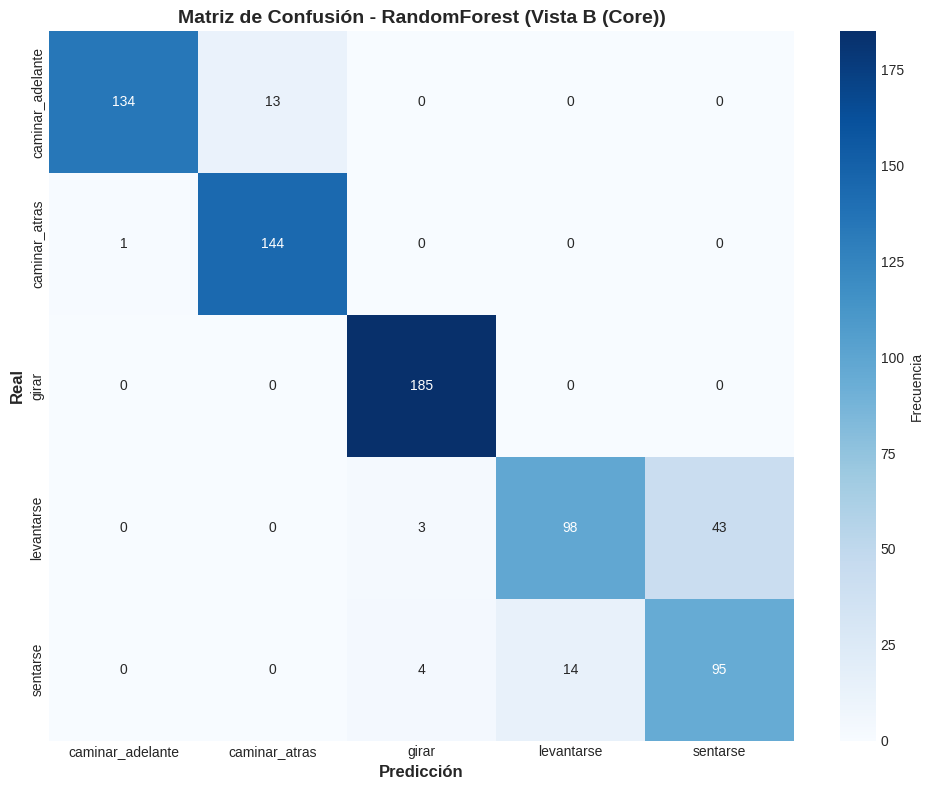

In [27]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix

# Obtener clases originales (convertir de números a nombres)
label_encoder = best_data['label_encoder']
classes = label_encoder.classes_

# Calcular matriz
cm = confusion_matrix(best_data['y_test'], best_result['y_test_pred'])

# Graficar
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Frecuencia'})
ax.set_xlabel('Predicción', fontsize=12, fontweight='bold')
ax.set_ylabel('Real', fontsize=12, fontweight='bold')
ax.set_title(f'Matriz de Confusión - {best_model_name} ({best_view})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [28]:
# Reporte completo por clase
from sklearn.metrics import classification_report

# Convertir predicciones de vuelta a nombres
y_test_names = label_encoder.inverse_transform(best_data['y_test'])
y_pred_names = label_encoder.inverse_transform(best_result['y_test_pred'])

print("\n" + "="*80)
print(f"REPORTE DE CLASIFICACIÓN - {best_model_name} ({best_view})")
print("="*80)
print(classification_report(y_test_names, y_pred_names))

# Análisis por clase
report_dict = classification_report(y_test_names, y_pred_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.iloc[:-3, :].sort_values('f1-score', ascending=False)

print("\n📊 Clases ordenadas por F1-score:")
print(report_df[['precision', 'recall', 'f1-score', 'support']])


REPORTE DE CLASIFICACIÓN - RandomForest (Vista B (Core))
                  precision    recall  f1-score   support

caminar_adelante       0.99      0.91      0.95       147
   caminar_atras       0.92      0.99      0.95       145
           girar       0.96      1.00      0.98       185
      levantarse       0.88      0.68      0.77       144
        sentarse       0.69      0.84      0.76       113

        accuracy                           0.89       734
       macro avg       0.89      0.89      0.88       734
    weighted avg       0.90      0.89      0.89       734


📊 Clases ordenadas por F1-score:
                  precision    recall  f1-score  support
girar              0.963542  1.000000  0.981432    185.0
caminar_atras      0.917197  0.993103  0.953642    145.0
caminar_adelante   0.992593  0.911565  0.950355    147.0
levantarse         0.875000  0.680556  0.765625    144.0
sentarse           0.688406  0.840708  0.756972    113.0


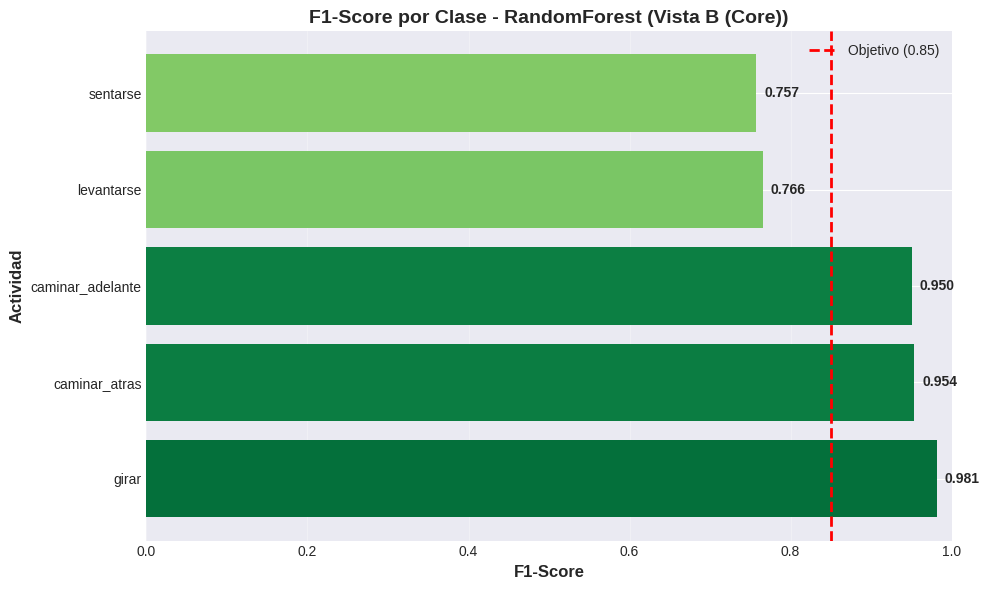

In [29]:
# Gráfica de F1 por clase
fig, ax = plt.subplots(figsize=(10, 6))

classes_sorted = report_df.index
f1_scores = report_df['f1-score']

colors = plt.cm.RdYlGn(f1_scores)
bars = ax.barh(classes_sorted, f1_scores, color=colors)

ax.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Actividad', fontsize=12, fontweight='bold')
ax.set_title(f'F1-Score por Clase - {best_model_name} ({best_view})',
             fontsize=14, fontweight='bold')
ax.axvline(x=0.85, color='red', linestyle='--', linewidth=2, label='Objetivo (0.85)')
ax.legend()
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 1])

# Anotar valores
for i, (cls, score) in enumerate(zip(classes_sorted, f1_scores)):
    ax.text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


TOP 20 FEATURES MÁS IMPORTANTES
                  feature  importance
          nose_confidence    0.076904
          nose_velocity_x    0.050395
              right_hip_z    0.049197
               left_hip_y    0.047166
               left_hip_z    0.046636
              right_hip_y    0.045646
 left_shoulder_confidence    0.043611
          left_shoulder_x    0.039639
          left_shoulder_z    0.038998
right_shoulder_confidence    0.037953
 left_shoulder_velocity_x    0.037008
          left_shoulder_y    0.034777
      left_hip_velocity_x    0.033826
right_shoulder_velocity_x    0.033249
     right_hip_velocity_x    0.030392
         right_shoulder_y    0.029992
              right_hip_x    0.029219
         right_shoulder_x    0.027930
      left_hip_confidence    0.026642
               left_hip_x    0.026597


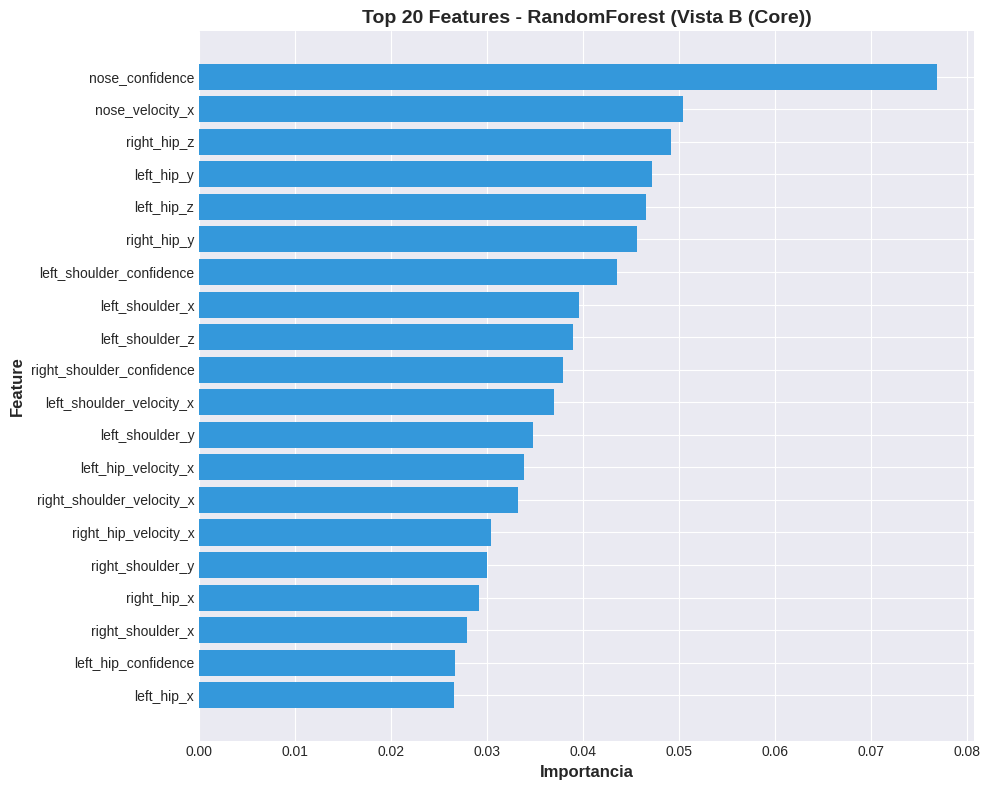

In [30]:
# Feature importance
importances = best_model.feature_importances_
feature_names = best_data['feature_names']

# Crear DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Top 20
top_features = feature_importance_df.head(20)

print("\n" + "="*80)
print("TOP 20 FEATURES MÁS IMPORTANTES")
print("="*80)
print(top_features.to_string(index=False))

# Gráfica
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_features)), top_features['importance'], color='#3498db')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'Top 20 Features - {best_model_name} ({best_view})',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [31]:
# Análisis de errores
print("\n" + "="*80)
print("ANÁLISIS DE ERRORES")
print("="*80)

# Matriz normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Encontrar los errores más comunes
errors = []
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j and cm[i, j] > 0:
            errors.append({
                'Real': classes[i],
                'Predicho': classes[j],
                'Count': cm[i, j],
                'Porcentaje': cm_norm[i, j] * 100
            })

errors_df = pd.DataFrame(errors).sort_values('Count', ascending=False)

print("\n📊 Pares más confundidos:")
print(errors_df.head(10).to_string(index=False))

if len(errors_df) > 0:
    top_error = errors_df.iloc[0]
    print(f"\n INTERPRETACIÓN:")
    print(f"El error más frecuente es confundir '{top_error['Real']}' con '{top_error['Predicho']}'")
    print(f"Ocurre en {top_error['Count']} frames ({top_error['Porcentaje']:.1f}% de los casos)")
    print(f"\n Posibles razones:")
    print(f"  - Movimientos similares en transiciones")
    print(f"  - Velocidad afectando la distinción")
    print(f"  - Postura intermedia entre ambas actividades")



ANÁLISIS DE ERRORES

📊 Pares más confundidos:
            Real         Predicho  Count  Porcentaje
      levantarse         sentarse     43   29.861111
        sentarse       levantarse     14   12.389381
caminar_adelante    caminar_atras     13    8.843537
        sentarse            girar      4    3.539823
      levantarse            girar      3    2.083333
   caminar_atras caminar_adelante      1    0.689655

 INTERPRETACIÓN:
El error más frecuente es confundir 'levantarse' con 'sentarse'
Ocurre en 43 frames (29.9% de los casos)

 Posibles razones:
  - Movimientos similares en transiciones
  - Velocidad afectando la distinción
  - Postura intermedia entre ambas actividades


In [32]:
# Análisis por velocidad (lento vs rápido)
print("\n" + "="*80)
print("ANÁLISIS ESTRATIFICADO POR VELOCIDAD")
print("="*80)

for speed_cat in ['lento', 'rapido']:
    mask = best_data['speed_test'] == speed_cat

    if mask.sum() > 0:
        y_true_speed = best_data['y_test'][mask]
        y_pred_speed = best_result['y_test_pred'][mask]

        # Convertir a nombres
        y_true_names = label_encoder.inverse_transform(y_true_speed)
        y_pred_names = label_encoder.inverse_transform(y_pred_speed)

        f1_speed = f1_score(y_true_names, y_pred_names, average='macro')
        acc_speed = accuracy_score(y_true_names, y_pred_names)

        print(f"\n{'='*60}")
        print(f"{speed_cat.upper()}:")
        print(f"{'='*60}")
        print(f"  Frames: {mask.sum()}")
        print(f"  F1-macro: {f1_speed:.4f}")
        print(f"  Accuracy: {acc_speed:.4f}")
        print(f"\n  Reporte por clase:")
        print(classification_report(y_true_names, y_pred_names, zero_division=0))


ANÁLISIS ESTRATIFICADO POR VELOCIDAD

LENTO:
  Frames: 264
  F1-macro: 0.9962
  Accuracy: 0.9962

  Reporte por clase:
                  precision    recall  f1-score   support

caminar_adelante       0.98      1.00      0.99        62
   caminar_atras       1.00      0.99      1.00       145
      levantarse       1.00      1.00      1.00        57

        accuracy                           1.00       264
       macro avg       0.99      1.00      1.00       264
    weighted avg       1.00      1.00      1.00       264


RAPIDO:
  Frames: 470
  F1-macro: 0.6466
  Accuracy: 0.8362

  Reporte por clase:
                  precision    recall  f1-score   support

caminar_adelante       1.00      0.85      0.92        85
   caminar_atras       0.00      0.00      0.00         0
           girar       0.96      1.00      0.98       185
      levantarse       0.75      0.47      0.58        87
        sentarse       0.69      0.84      0.76       113

        accuracy                      